# Imports and Settings

In [1]:
import os
import sys
import time
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from keras.regularizers import l1_l2
from keras.optimizers import SGD, Adam
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, roc_curve, auc
from collections import OrderedDict, Counter
from tensorflow.python.ops import gen_array_ops
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, AveragePooling2D
from names import Names as n
from scipy.stats import gaussian_kde
from descartes import PolygonPatch
import alphashape
from sklearn.cluster import KMeans
from pathlib import Path
from harness.test_harness_class import TestHarness
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.weighted_logistic import weighted_logistic_classifier
from notebook_functions import *

In [75]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)
matplotlib.use("agg")
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
col_idx = OrderedDict([(n.label, 0), ("inducer_concentration", 1), ("timepoint", 2), ("percent_live", 3)])

# Configure Variables

In [5]:
data = pd.read_csv("experiment_data/processed/duke_v2.csv")
color_channel_to_use = "YL1"
use_stain_in_AutoGater = True

In [6]:
data["timepoint"].value_counts()

0.5    420000
0.0    420000
3.0    395213
6.0    378248
Name: timepoint, dtype: int64

In [7]:
df = data.loc[data["stain"] == 1]

In [8]:
stain_cols = ["{}-A".format(color_channel_to_use), 
              "{}-H".format(color_channel_to_use),
              "{}-W".format(color_channel_to_use)]
all_features = n.morph_cols + stain_cols

if use_stain_in_AutoGater:
    features = all_features
else:
    features = n.morph_cols
    
print("Features that we will use: {}".format(features))

Features that we will use: ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'YL1-A', 'YL1-H', 'YL1-W']


# Our equivalent of "samples" will be timepoint + concentration 
(maybe add replicates later)

# Model 1: sample-level prediction of >50% CFU percent_live

In [9]:
df1 = df.drop(columns=["source", "stain"]).reset_index(drop=True)
df1["cfu_live"] = (df1["percent_live"] > 50.0).astype(int)
df1

inducer_concentration  timepoint    FSC-A    SSC-A    YL1-A    FSC-H    SSC-H    YL1-H    FSC-W    SSC-W    YL1-W  percent_live  cfu_live
0                         0.0        0.0  6.02060  6.02060  4.90093  5.76444  5.41198  2.94052  3.00988  3.00988  0.00000     78.633333         1
1                         0.0        0.0  5.38945  4.59275  2.59770  5.37109  4.59422  2.41497  1.96379  1.87506  0.00000     78.633333         1
2                         0.0        0.0  5.45014  4.88310  2.40312  5.41537  4.84833  2.23300  1.94448  1.89763  0.00000     78.633333         1
3                         0.0        0.0  5.64436  5.11836  2.86629  5.58375  5.06345  2.63849  1.95424  1.94448  0.00000     78.633333         1
4                         0.0        0.0  5.25856  4.68307  1.80618  5.25983  4.68142  2.18184  1.90309  1.86332  0.00000     78.633333         1
...                       ...        ...      ...      ...      ...      ...      ...      ...      ...      ...      ...           ...       ...
802478                   80.0        6.0  5.40536  4.99815  5.04934  5.35042  4.95624  5.00503  1.93450  1.93450  1.96379      0.000000         0
802479                   80.0        6.0  5.45617  5.24021  5.20301  5.32792  5.15502  5.10656  1.97313  1.95904  1.97313      0.000000         0
802480                   80.0        6.0  5.23300  4.56023  4.79102  5.22052  4.56326  4.77915  1.88649  1.85733  1.92428      0.000000         0
802481                   80.0        6.0  5.53827  5.02246  4.97019  5.36166  4.87132  4.82215  2.01284  1.96848  1.98677      0.000000         0
802482                   80.0        6.0  5.33946  4.96542  4.92829  5.28929  4.92806  4.88089  1.96848  1.91381  1.93952      0.000000         0

[802483 rows x 13 columns]

In [10]:
# Need to repeat cells for the (80.0, 3.0) and (80, 6.0) conditions to reach 30000 like other conditions have. 
# Otherwise the X1 numpy array won't have the correct shape.
subset_80_3 = df1.loc[(df1["inducer_concentration"] == 80.0) & (df1["timepoint"] == 3.0)]
subset_80_6 = df1.loc[(df1["inducer_concentration"] == 80.0) & (df1["timepoint"] == 6.0)]

sampled_subset_80_3 = subset_80_3.sample(n=30000-len(subset_80_3), replace=True, random_state=1)
sampled_subset_80_6 = subset_80_6.sample(n=30000-len(subset_80_6), replace=True, random_state=1)

In [11]:
df1 = pd.concat([df1, sampled_subset_80_3, sampled_subset_80_6]).reset_index()

In [12]:
# df1.groupby(["inducer_concentration", "timepoint"]).count()

In [13]:
X1 = np.array(list(df1[["inducer_concentration", 
                        "timepoint"] + features].groupby(["inducer_concentration",
                                                          "timepoint"]).apply(pd.DataFrame.to_numpy)))
X1 = np.expand_dims(X1, axis=3)
# drop the columns corresponding to inducer_concentration and timepoint
X1 = X1[:, :, 2:, :]
print(X1.shape)
# display(X1)

(28, 30000, 9, 1)


In [14]:
y1 = df1.groupby(["inducer_concentration", "timepoint"], as_index=False).first()["cfu_live"].values
display(y1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [15]:
# split into train and test
np.random.seed(5)
train_idx = list(np.random.choice(len(X1), size=int(len(X1)*0.6), replace=False))
test_idx = [x for x in list(range(len(X1))) if x not in train_idx]
print("indices of training samples:", train_idx)
print("indices of testing samples:", test_idx)
X1_train = X1[train_idx]
X1_test = X1[test_idx]
print("shape of train matrix:", X1_train.shape)
print("shape of test matrix:", X1_test.shape)
print()
y1_train = y1[train_idx]
y1_test = y1[test_idx]
print("shape of y1_train:", y1_train.shape)
print("shape of y1_test:", y1_test.shape)

indices of training samples: [10, 27, 11, 20, 21, 2, 26, 24, 19, 13, 0, 25, 5, 1, 12, 18]
indices of testing samples: [3, 4, 6, 7, 8, 9, 14, 15, 16, 17, 22, 23]
shape of train matrix: (16, 30000, 9, 1)
shape of test matrix: (12, 30000, 9, 1)

shape of y1_train: (16,)
shape of y1_test: (12,)


In [16]:
# # temporary swap train and test
# temp = X1_train.copy()
# X1_train = X1_test.copy()
# X1_test = temp.copy()

# temp = y1_train.copy()
# y1_train = y1_test.copy()
# y1_test = temp.copy()

## Going to actually just train and test on entire dataset to match with AutoGater

In [17]:
X1_train = X1.copy()
X1_test = X1.copy()
y1_train = y1.copy()
y1_test = y1.copy()

### Define Model

In [18]:
# input
model_input = Input(shape=X1_train[0].shape)

# first convolution layer
model_output = Conv2D(3, kernel_size=(1, X1_train.shape[2]),
                 activation=None)(model_input)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# sceond convolution layer
model_output = Conv2D(3, (1, 1), activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# pooling layer
model_output = AveragePooling2D(pool_size=(X1_train.shape[1], 1))(model_output)
model_output = Flatten()(model_output)

# Dense layer
model_output = Dense(3, activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# output layer
model_output = Dense(1, activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("sigmoid")(model_output)

### Train Model

In [19]:
# specify input and output
model = Model(inputs=[model_input],
              outputs=model_output)

# define loss function and optimizer
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

# save the best performing model
checkpointer = ModelCheckpoint(filepath='Result/saved_weights.hdf5', 
                               monitor='val_loss', verbose=0, 
                               save_best_only=True)

# model training
model.fit([X1_train], y1_train,
          batch_size=60,
          epochs=500, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([X1_train], y1_train))

Epoch 1/500
1/1 [==============================] - 0s 301ms/step - loss: 1.0962 - accuracy: 0.1786 - val_loss: 0.7323 - val_accuracy: 0.5714
Epoch 2/500
1/1 [==============================] - 0s 89ms/step - loss: 1.0956 - accuracy: 0.1786 - val_loss: 0.7311 - val_accuracy: 0.5714
Epoch 3/500
1/1 [==============================] - 0s 77ms/step - loss: 1.0948 - accuracy: 0.1786 - val_loss: 0.7299 - val_accuracy: 0.5714
Epoch 4/500
1/1 [==============================] - 0s 88ms/step - loss: 1.0940 - accuracy: 0.1786 - val_loss: 0.7287 - val_accuracy: 0.5714
Epoch 5/500
1/1 [==============================] - 0s 79ms/step - loss: 1.0930 - accuracy: 0.1786 - val_loss: 0.7275 - val_accuracy: 0.5714
Epoch 6/500
1/1 [==============================] - 0s 78ms/step - loss: 1.0923 - accuracy: 0.1786 - val_loss: 0.7263 - val_accuracy: 0.5714
Epoch 7/500
1/1 [==============================] - 0s 84ms/step - loss: 1.0914 - accuracy: 0.1786 - val_loss: 0.7251 - val_accuracy: 0.5714
Epoch 8/500
1/1 [==

1/1 [==============================] - 0s 76ms/step - loss: 1.0195 - accuracy: 0.1786 - val_loss: 0.6853 - val_accuracy: 0.5714
Epoch 60/500
1/1 [==============================] - 0s 77ms/step - loss: 1.0171 - accuracy: 0.1786 - val_loss: 0.6850 - val_accuracy: 0.5714
Epoch 61/500
1/1 [==============================] - 0s 113ms/step - loss: 1.0142 - accuracy: 0.1786 - val_loss: 0.6846 - val_accuracy: 0.6071
Epoch 62/500
1/1 [==============================] - 0s 75ms/step - loss: 1.0126 - accuracy: 0.1786 - val_loss: 0.6842 - val_accuracy: 0.6071
Epoch 63/500
1/1 [==============================] - 0s 78ms/step - loss: 1.0098 - accuracy: 0.1786 - val_loss: 0.6838 - val_accuracy: 0.6071
Epoch 64/500
1/1 [==============================] - 0s 76ms/step - loss: 1.0072 - accuracy: 0.1786 - val_loss: 0.6834 - val_accuracy: 0.6071
Epoch 65/500
1/1 [==============================] - 0s 78ms/step - loss: 1.0044 - accuracy: 0.1786 - val_loss: 0.6831 - val_accuracy: 0.6071
Epoch 66/500
1/1 [=======

1/1 [==============================] - 0s 84ms/step - loss: 0.7665 - accuracy: 0.5357 - val_loss: 0.6667 - val_accuracy: 0.4286
Epoch 118/500
1/1 [==============================] - 0s 115ms/step - loss: 0.7613 - accuracy: 0.5714 - val_loss: 0.6663 - val_accuracy: 0.4286
Epoch 119/500
1/1 [==============================] - 0s 78ms/step - loss: 0.7556 - accuracy: 0.5714 - val_loss: 0.6658 - val_accuracy: 0.4286
Epoch 120/500
1/1 [==============================] - 0s 80ms/step - loss: 0.7498 - accuracy: 0.6786 - val_loss: 0.6654 - val_accuracy: 0.4286
Epoch 121/500
1/1 [==============================] - 0s 80ms/step - loss: 0.7447 - accuracy: 0.6786 - val_loss: 0.6650 - val_accuracy: 0.4286
Epoch 122/500
1/1 [==============================] - 0s 79ms/step - loss: 0.7390 - accuracy: 0.6786 - val_loss: 0.6646 - val_accuracy: 0.4286
Epoch 123/500
1/1 [==============================] - 0s 79ms/step - loss: 0.7327 - accuracy: 0.6786 - val_loss: 0.6642 - val_accuracy: 0.4286
Epoch 124/500
1/1 [

Epoch 175/500
1/1 [==============================] - 0s 113ms/step - loss: 0.5221 - accuracy: 0.8214 - val_loss: 0.6397 - val_accuracy: 0.4286
Epoch 176/500
1/1 [==============================] - 0s 79ms/step - loss: 0.5201 - accuracy: 0.8214 - val_loss: 0.6389 - val_accuracy: 0.4286
Epoch 177/500
1/1 [==============================] - 0s 81ms/step - loss: 0.5188 - accuracy: 0.8214 - val_loss: 0.6381 - val_accuracy: 0.4286
Epoch 178/500
1/1 [==============================] - 0s 78ms/step - loss: 0.5179 - accuracy: 0.8214 - val_loss: 0.6373 - val_accuracy: 0.4286
Epoch 179/500
1/1 [==============================] - 0s 79ms/step - loss: 0.5165 - accuracy: 0.8214 - val_loss: 0.6365 - val_accuracy: 0.4286
Epoch 180/500
1/1 [==============================] - 0s 79ms/step - loss: 0.5160 - accuracy: 0.8571 - val_loss: 0.6357 - val_accuracy: 0.4286
Epoch 181/500
1/1 [==============================] - 0s 78ms/step - loss: 0.5144 - accuracy: 0.8571 - val_loss: 0.6348 - val_accuracy: 0.4286
Epoch

1/1 [==============================] - 0s 111ms/step - loss: 0.4825 - accuracy: 0.8571 - val_loss: 0.5691 - val_accuracy: 0.6071
Epoch 233/500
1/1 [==============================] - 0s 78ms/step - loss: 0.4822 - accuracy: 0.8571 - val_loss: 0.5677 - val_accuracy: 0.6071
Epoch 234/500
1/1 [==============================] - 0s 81ms/step - loss: 0.4816 - accuracy: 0.8571 - val_loss: 0.5664 - val_accuracy: 0.6071
Epoch 235/500
1/1 [==============================] - 0s 82ms/step - loss: 0.4812 - accuracy: 0.8571 - val_loss: 0.5651 - val_accuracy: 0.6071
Epoch 236/500
1/1 [==============================] - 0s 80ms/step - loss: 0.4808 - accuracy: 0.8571 - val_loss: 0.5638 - val_accuracy: 0.6071
Epoch 237/500
1/1 [==============================] - 0s 77ms/step - loss: 0.4805 - accuracy: 0.8571 - val_loss: 0.5625 - val_accuracy: 0.6071
Epoch 238/500
1/1 [==============================] - 0s 79ms/step - loss: 0.4799 - accuracy: 0.8571 - val_loss: 0.5612 - val_accuracy: 0.6071
Epoch 239/500
1/1 [

Epoch 290/500
1/1 [==============================] - 0s 76ms/step - loss: 0.4650 - accuracy: 0.8929 - val_loss: 0.5017 - val_accuracy: 0.8929
Epoch 291/500
1/1 [==============================] - 0s 77ms/step - loss: 0.4649 - accuracy: 0.8929 - val_loss: 0.5007 - val_accuracy: 0.8929
Epoch 292/500
1/1 [==============================] - 0s 76ms/step - loss: 0.4646 - accuracy: 0.8929 - val_loss: 0.4997 - val_accuracy: 0.8929
Epoch 293/500
1/1 [==============================] - 0s 77ms/step - loss: 0.4644 - accuracy: 0.8929 - val_loss: 0.4987 - val_accuracy: 0.8929
Epoch 294/500
1/1 [==============================] - 0s 75ms/step - loss: 0.4642 - accuracy: 0.8929 - val_loss: 0.4976 - val_accuracy: 0.8929
Epoch 295/500
1/1 [==============================] - 0s 75ms/step - loss: 0.4640 - accuracy: 0.8929 - val_loss: 0.4966 - val_accuracy: 0.8929
Epoch 296/500
1/1 [==============================] - 0s 77ms/step - loss: 0.4638 - accuracy: 0.8929 - val_loss: 0.4956 - val_accuracy: 0.8929
Epoch 

1/1 [==============================] - 0s 74ms/step - loss: 0.4553 - accuracy: 0.8929 - val_loss: 0.4558 - val_accuracy: 0.9286
Epoch 348/500
1/1 [==============================] - 0s 90ms/step - loss: 0.4553 - accuracy: 0.8929 - val_loss: 0.4553 - val_accuracy: 0.9286
Epoch 349/500
1/1 [==============================] - 0s 78ms/step - loss: 0.4550 - accuracy: 0.8929 - val_loss: 0.4548 - val_accuracy: 0.9286
Epoch 350/500
1/1 [==============================] - 0s 79ms/step - loss: 0.4549 - accuracy: 0.8929 - val_loss: 0.4543 - val_accuracy: 0.9286
Epoch 351/500
1/1 [==============================] - 0s 78ms/step - loss: 0.4547 - accuracy: 0.8929 - val_loss: 0.4538 - val_accuracy: 0.9286
Epoch 352/500
1/1 [==============================] - 0s 78ms/step - loss: 0.4547 - accuracy: 0.8929 - val_loss: 0.4533 - val_accuracy: 0.9286
Epoch 353/500
1/1 [==============================] - 0s 80ms/step - loss: 0.4545 - accuracy: 0.8929 - val_loss: 0.4528 - val_accuracy: 0.9286
Epoch 354/500
1/1 [=

Epoch 405/500
1/1 [==============================] - 0s 78ms/step - loss: 0.4473 - accuracy: 0.8929 - val_loss: 0.4334 - val_accuracy: 0.9643
Epoch 406/500
1/1 [==============================] - 0s 79ms/step - loss: 0.4471 - accuracy: 0.8929 - val_loss: 0.4332 - val_accuracy: 0.9643
Epoch 407/500
1/1 [==============================] - 0s 77ms/step - loss: 0.4470 - accuracy: 0.8929 - val_loss: 0.4330 - val_accuracy: 0.9643
Epoch 408/500
1/1 [==============================] - 0s 77ms/step - loss: 0.4469 - accuracy: 0.8929 - val_loss: 0.4329 - val_accuracy: 0.9643
Epoch 409/500
1/1 [==============================] - 0s 77ms/step - loss: 0.4468 - accuracy: 0.8929 - val_loss: 0.4327 - val_accuracy: 0.9643
Epoch 410/500
1/1 [==============================] - 0s 77ms/step - loss: 0.4468 - accuracy: 0.8929 - val_loss: 0.4325 - val_accuracy: 0.9643
Epoch 411/500
1/1 [==============================] - 0s 79ms/step - loss: 0.4465 - accuracy: 0.8929 - val_loss: 0.4323 - val_accuracy: 0.9643
Epoch 

1/1 [==============================] - 0s 80ms/step - loss: 0.4411 - accuracy: 0.8929 - val_loss: 0.4288 - val_accuracy: 0.9643
Epoch 463/500
1/1 [==============================] - 0s 76ms/step - loss: 0.4411 - accuracy: 0.8929 - val_loss: 0.4289 - val_accuracy: 0.9643
Epoch 464/500
1/1 [==============================] - 0s 78ms/step - loss: 0.4411 - accuracy: 0.8929 - val_loss: 0.4289 - val_accuracy: 0.9643
Epoch 465/500
1/1 [==============================] - 0s 78ms/step - loss: 0.4409 - accuracy: 0.8929 - val_loss: 0.4290 - val_accuracy: 0.9643
Epoch 466/500
1/1 [==============================] - 0s 79ms/step - loss: 0.4407 - accuracy: 0.8929 - val_loss: 0.4290 - val_accuracy: 0.9643
Epoch 467/500
1/1 [==============================] - 0s 81ms/step - loss: 0.4408 - accuracy: 0.8929 - val_loss: 0.4291 - val_accuracy: 0.9643
Epoch 468/500
1/1 [==============================] - 0s 82ms/step - loss: 0.4406 - accuracy: 0.8929 - val_loss: 0.4290 - val_accuracy: 0.9643
Epoch 469/500
1/1 [=

### Plot losses

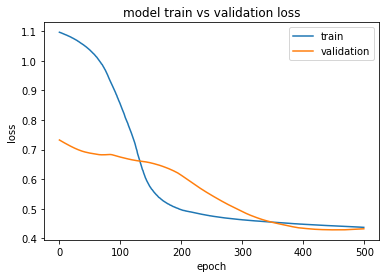

In [20]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Evaluate on test data

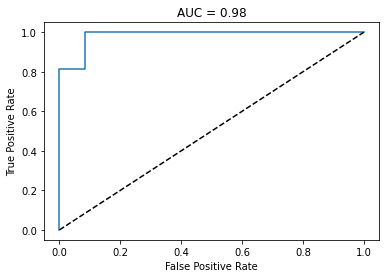

In [21]:
# # load final model
# final_model = load_model('Data/Final_weights.hdf5')

# generate ROC and AUC
y_scores = model.predict([X1_test])
fpr, tpr, _ = roc_curve(y1_test, y_scores)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = {0:.2f}'.format(roc_auc))
plt.show()

# Obtain Activations

In [22]:
print(X1_train.shape)
print(X1_test.shape)

(28, 30000, 9, 1)
(28, 30000, 9, 1)


In [23]:
# Extract the Model Outputs for all the Layers
Model_Outputs = [layer.output for layer in model.layers]
# Create a Model with Model Input as Input and the Model Outputs as Output
Activation_Model = Model(model.input, Model_Outputs)
activations_train = Activation_Model.predict(X1_train)
activations_test = Activation_Model.predict(X1_test)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30000, 9, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30000, 1, 3)       30        
_________________________________________________________________
batch_normalization (BatchNo (None, 30000, 1, 3)       12        
_________________________________________________________________
activation (Activation)      (None, 30000, 1, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30000, 1, 3)       12        
_________________________________________________________________
batch_normalization_1 (Batch (None, 30000, 1, 3)       12        
_________________________________________________________________
activation_1 (Activation)    (None, 30000, 1, 3)       0     

In [25]:
for layer in activations_test:
    print(layer.shape)

(28, 30000, 9, 1)
(28, 30000, 1, 3)
(28, 30000, 1, 3)
(28, 30000, 1, 3)
(28, 30000, 1, 3)
(28, 30000, 1, 3)
(28, 30000, 1, 3)
(28, 1, 1, 3)
(28, 3)
(28, 3)
(28, 3)
(28, 3)
(28, 1)
(28, 1)
(28, 1)


In [26]:
# check if first layer activations are the same as X1_test
first_layer_activations = activations_test[0]
np.allclose(first_layer_activations, X1_test)

True

In [27]:
conv2d_0_activations = activations_test[1]
conv2d_1_activations = activations_test[4]

In [28]:
conv2d_0_activations.shape

(28, 30000, 1, 3)

In [29]:
conv2d_1_activations.shape

(28, 30000, 1, 3)

^ 28 samples, 30000 cells, across 3 filters --> 3 activation values for each cell in each sample

# AutoGater Predictions

In [30]:
from notebook_functions import *

col_idx = OrderedDict([(n.label, 0), ("inducer_concentration", 1), ("timepoint", 2), ("percent_live", 3)])

In [31]:
df_with_rfc_labels, X, Y = generate_rf_labels_from_conditions(df1, features)

Conditions designated as Live: [{'inducer_concentration': 0.0, 'timepoint': 6.0}]
Conditions designated as Dead: [{'inducer_concentration': 20.0, 'timepoint': 6.0}, {'inducer_concentration': 80.0, 'timepoint': 6.0}]


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 15:37:17
Starting Classification training...
Training time was: 13.31 seconds
Testing time was: 1.06 seconds
Prediction time of untested data was: 13.10325288772583
Run finished at 15:37:50. Total run time = 33.01 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^





Model Boosting took 238.9592990875244 seconds
Training Accuracy = 96.82%
Counter({1: 540913, 0: 299087})
Instructions for updating:
Please use `model.predict()` instead.


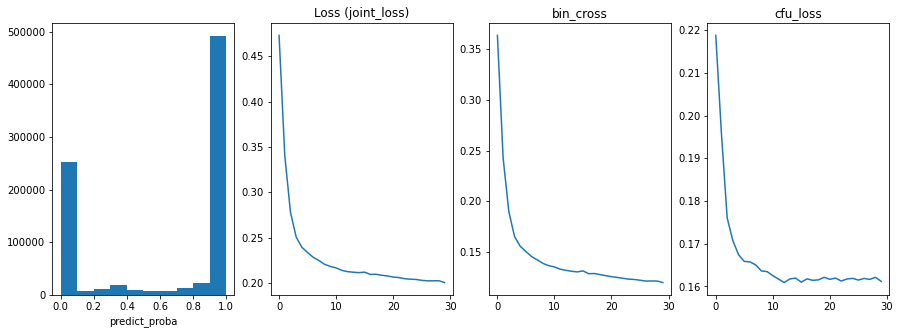

In [32]:
condition_results, preds_and_labels = run_model(model_function=booster_model_v2, lr=0.001,
                                                loss = joint_loss_wrapper(0.5), 
                                                metrics = [bin_cross, cfu_loss],
                                                X = X, Y = Y, epochs = 30, batch_size = 2048,
                                                verbose = False, shuffle = True, plot_type="line")

# Correlate activations with AutoGater predictions

In [33]:
preds_and_labels

label  inducer_concentration  timepoint  cfu_percent_live  nn_preds
0       100.0                    0.0        0.0         78.633333       100
1       100.0                    0.0        0.0         78.633333       100
2       100.0                    0.0        0.0         78.633333       100
3       100.0                    0.0        0.0         78.633333       100
4       100.0                    0.0        0.0         78.633333       100
...       ...                    ...        ...               ...       ...
839995    0.0                   80.0        6.0          0.000000         0
839996    0.0                   80.0        6.0          0.000000         0
839997    0.0                   80.0        6.0          0.000000         0
839998    0.0                   80.0        6.0          0.000000         0
839999    0.0                   80.0        6.0          0.000000         0

[840000 rows x 5 columns]

In [34]:
autogater_preds = preds_and_labels["nn_preds"]

In [35]:
corr_df = pd.DataFrame()
corr_df["autogater_preds"] = autogater_preds / 100
corr_df["conv2d_0_filter_1_activations"] = conv2d_0_activations.reshape(840000, 3)[:, 0]
corr_df["conv2d_0_filter_2_activations"] = conv2d_0_activations.reshape(840000, 3)[:, 1]
corr_df["conv2d_0_filter_3_activations"] = conv2d_0_activations.reshape(840000, 3)[:, 2]
corr_df["conv2d_1_filter_1_activations"] = conv2d_1_activations.reshape(840000, 3)[:, 0]
corr_df["conv2d_1_filter_2_activations"] = conv2d_1_activations.reshape(840000, 3)[:, 1]
corr_df["conv2d_1_filter_3_activations"] = conv2d_1_activations.reshape(840000, 3)[:, 2]

In [36]:
corr_df

autogater_preds  conv2d_0_filter_1_activations  conv2d_0_filter_2_activations  conv2d_0_filter_3_activations  conv2d_1_filter_1_activations  conv2d_1_filter_2_activations  conv2d_1_filter_3_activations
0                   1.0                      -8.094414                       1.396035                       1.272620                       0.392310                       0.135100                      -0.486138
1                   1.0                      -6.437889                       1.596606                       0.669974                      -0.391624                       0.475610                      -0.318230
2                   1.0                      -6.599614                       1.707145                       0.450225                      -0.008236                       0.028540                      -0.006938
3                   1.0                      -6.901008                       1.695778                       0.643631                      -0.000205                       0.019175                      -0.000418
4                   1.0                      -6.389129                       1.729061                       0.257663                      -0.507215                       0.610400                      -0.412083
...                 ...                            ...                            ...                            ...                            ...                            ...                            ...
839995              0.0                      -6.795312                       1.868501                       2.477134                       1.187871                       0.699963                      -1.859083
839996              0.0                      -6.879644                       1.874510                       2.485806                       1.180130                       0.730298                      -1.887917
839997              0.0                      -6.941887                       2.108518                       1.007788                      -0.542031                       1.492014                      -1.252683
839998              0.0                      -6.632092                       1.816794                       2.472097                       1.308925                       0.455020                      -1.678354
839999              0.0                      -6.463368                       1.760196                       2.497999                       1.020089                       0.804268                      -1.941374

[840000 rows x 7 columns]

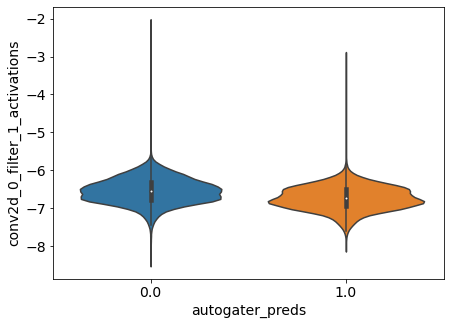

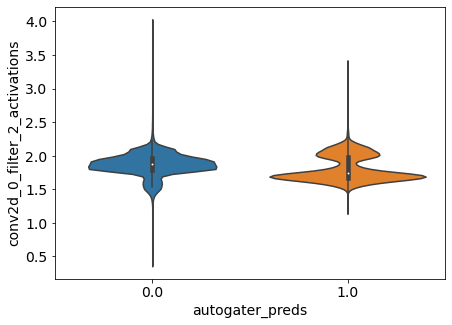

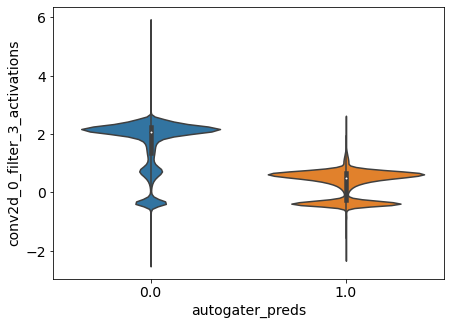

In [37]:
for cnn_filter in ["conv2d_0_filter_1_activations", "conv2d_0_filter_2_activations", "conv2d_0_filter_3_activations"]:
    matplotlib.rcParams.update({'font.size': 14})
    plt.figure(figsize=(7, 5))
#     plt.ylim(-5, 11)
    sns.violinplot(data=corr_df, x="autogater_preds", y=cnn_filter)

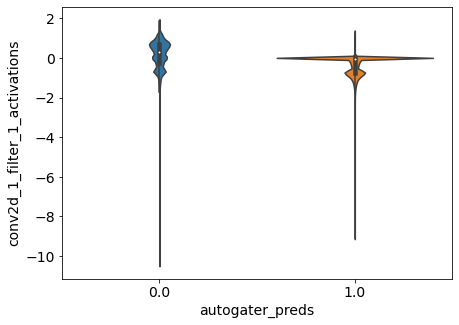

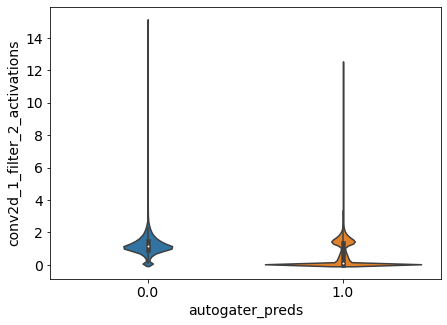

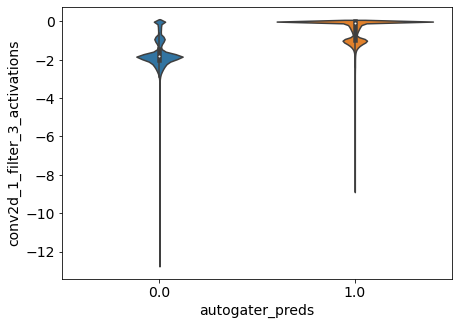

In [38]:
for cnn_filter in ["conv2d_1_filter_1_activations", "conv2d_1_filter_2_activations", "conv2d_1_filter_3_activations"]:
    matplotlib.rcParams.update({'font.size': 14})
    plt.figure(figsize=(7, 5))
#     plt.ylim(-5, 11)
    sns.violinplot(data=corr_df, x="autogater_preds", y=cnn_filter)

In [39]:
th = TestHarness(output_location="th_cytof_results")

In [40]:
filter_1_acts = ["conv2d_0_filter_1_activations", "conv2d_0_filter_2_activations", "conv2d_0_filter_3_activations"]
filter_2_acts = ["conv2d_1_filter_1_activations", "conv2d_1_filter_2_activations", "conv2d_1_filter_3_activations"]
all_acts = filter_1_acts + filter_2_acts

In [41]:
th.run_custom(function_that_returns_TH_model=random_forest_classification, dict_of_function_parameters={},
              training_data=corr_df, testing_data=corr_df, target_cols="autogater_preds", 
              feature_cols_to_use=filter_1_acts,
              description="predict autogater live/dead from filter_1's 3 CNN Activations", 
              index_cols=all_acts)

----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 15:42:44
Starting Classification training...
Training time was: 199.91 seconds
Testing time was: 20.62 seconds
Run finished at 15:46:42. Total run time = 238.61 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




In [42]:
th.run_custom(function_that_returns_TH_model=random_forest_classification, dict_of_function_parameters={},
              training_data=corr_df, testing_data=corr_df, target_cols="autogater_preds", 
              feature_cols_to_use=filter_2_acts, 
              description="predict autogater live/dead from filter_2's 3 CNN Activations", 
              index_cols=all_acts)

----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 15:46:42
Starting Classification training...
Training time was: 146.22 seconds
Testing time was: 17.57 seconds
Run finished at 15:49:44. Total run time = 182.01 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




In [43]:
th.run_custom(function_that_returns_TH_model=random_forest_classification, dict_of_function_parameters={},
              training_data=corr_df, testing_data=corr_df, target_cols="autogater_preds", 
              feature_cols_to_use=all_acts, description="predict autogater live/dead from 6 CNN Activations", 
              index_cols=all_acts)

----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 15:49:45
Starting Classification training...
Training time was: 267.58 seconds
Testing time was: 21.29 seconds
Run finished at 15:54:52. Total run time = 306.95 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




In [44]:
run_info = get_all_run_info(df_with_rfc_labels, X, preds_and_labels)

In [45]:
run_info

FSC-A    FSC-H    FSC-W    SSC-A    SSC-H    SSC-W    YL1-A    YL1-H    YL1-W  label  inducer_concentration  timepoint  cfu_percent_live  nn_preds  changed    change_type  nn_percent_live  label_probs
0       6.02060  5.76444  3.00988  6.02060  5.41198  3.00988  4.90093  2.94052  0.00000    1.0                    0.0        0.0         78.633333       1.0    False  Remained Live        76.213333     0.958847
1       5.38945  5.37109  1.96379  4.59275  4.59422  1.87506  2.59770  2.41497  0.00000    1.0                    0.0        0.0         78.633333       1.0    False  Remained Live        76.213333     0.998211
2       5.45014  5.41537  1.94448  4.88310  4.84833  1.89763  2.40312  2.23300  0.00000    1.0                    0.0        0.0         78.633333       1.0    False  Remained Live        76.213333     0.997789
3       5.64436  5.58375  1.95424  5.11836  5.06345  1.94448  2.86629  2.63849  0.00000    1.0                    0.0        0.0         78.633333       1.0    False  Remained Live        76.213333     0.998352
4       5.25856  5.25983  1.90309  4.68307  4.68142  1.86332  1.80618  2.18184  0.00000    1.0                    0.0        0.0         78.633333       1.0    False  Remained Live        76.213333     0.981664
...         ...      ...      ...      ...      ...      ...      ...      ...      ...    ...                    ...        ...               ...       ...      ...            ...              ...          ...
839995  5.49738  5.38096  1.98227  4.90883  4.81175  1.93952  5.00514  4.89230  1.95904    0.0                   80.0        6.0          0.000000       0.0    False  Remained Dead         0.056667     0.000000
839996  5.46159  5.42934  1.91908  4.97690  4.95374  1.91908  5.07713  5.05451  1.94448    0.0                   80.0        6.0          0.000000       0.0    False  Remained Dead         0.056667     0.001043
839997  4.94044  4.90913  1.86332  5.66319  5.65128  1.90849  3.43233  3.34044  1.34242    0.0                   80.0        6.0          0.000000       0.0    False  Remained Dead         0.056667     0.000000
839998  5.34477  5.31678  1.91381  4.71785  4.69970  1.89209  4.91763  4.89063  1.92942    0.0                   80.0        6.0          0.000000       0.0    False  Remained Dead         0.056667     0.000000
839999  5.28881  5.26145  1.88649  4.54065  4.50695  1.87506  4.86633  4.84003  1.92942    0.0                   80.0        6.0          0.000000       0.0    False  Remained Dead         0.056667     0.000000

[840000 rows x 18 columns]

In [78]:
feat_df = pd.DataFrame()
feat_df["conv2d_0_filter_1_activations"] = conv2d_0_activations.reshape(840000, 3)[:, 0]
feat_df["conv2d_0_filter_2_activations"] = conv2d_0_activations.reshape(840000, 3)[:, 1]
feat_df["conv2d_0_filter_3_activations"] = conv2d_0_activations.reshape(840000, 3)[:, 2]
feat_df["conv2d_1_filter_1_activations"] = conv2d_1_activations.reshape(840000, 3)[:, 0]
feat_df["conv2d_1_filter_2_activations"] = conv2d_1_activations.reshape(840000, 3)[:, 1]
feat_df["conv2d_1_filter_3_activations"] = conv2d_1_activations.reshape(840000, 3)[:, 2]
feat_df["FSC-A"] = run_info["FSC-A"]
feat_df["SSC-A"] = run_info["SSC-A"]
feat_df["YL1-H"] = run_info["YL1-H"]
feat_df["autogater_preds"] = run_info["nn_preds"]

In [79]:
feat_df

conv2d_0_filter_1_activations  conv2d_0_filter_2_activations  conv2d_0_filter_3_activations  conv2d_1_filter_1_activations  conv2d_1_filter_2_activations  conv2d_1_filter_3_activations    FSC-A    SSC-A    YL1-H  autogater_preds
0                           -8.094414                       1.396035                       1.272620                       0.392310                       0.135100                      -0.486138  6.02060  6.02060  2.94052              1.0
1                           -6.437889                       1.596606                       0.669974                      -0.391624                       0.475610                      -0.318230  5.38945  4.59275  2.41497              1.0
2                           -6.599614                       1.707145                       0.450225                      -0.008236                       0.028540                      -0.006938  5.45014  4.88310  2.23300              1.0
3                           -6.901008                       1.695778                       0.643631                      -0.000205                       0.019175                      -0.000418  5.64436  5.11836  2.63849              1.0
4                           -6.389129                       1.729061                       0.257663                      -0.507215                       0.610400                      -0.412083  5.25856  4.68307  2.18184              1.0
...                               ...                            ...                            ...                            ...                            ...                            ...      ...      ...      ...              ...
839995                      -6.795312                       1.868501                       2.477134                       1.187871                       0.699963                      -1.859083  5.49738  4.90883  4.89230              0.0
839996                      -6.879644                       1.874510                       2.485806                       1.180130                       0.730298                      -1.887917  5.46159  4.97690  5.05451              0.0
839997                      -6.941887                       2.108518                       1.007788                      -0.542031                       1.492014                      -1.252683  4.94044  5.66319  3.34044              0.0
839998                      -6.632092                       1.816794                       2.472097                       1.308925                       0.455020                      -1.678354  5.34477  4.71785  4.89063              0.0
839999                      -6.463368                       1.760196                       2.497999                       1.020089                       0.804268                      -1.941374  5.28881  4.54065  4.84003              0.0

[840000 rows x 10 columns]

In [48]:
th.run_custom(function_that_returns_TH_model=random_forest_classification, dict_of_function_parameters={},
              training_data=feat_df, testing_data=corr_df, target_cols="autogater_preds", 
              feature_cols_to_use=all_acts, description="asdf", 
              index_cols=all_acts)

----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 15:54:53
Starting Classification training...
Training time was: 267.67 seconds
Testing time was: 18.95 seconds
Run finished at 15:59:57. Total run time = 304.40 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




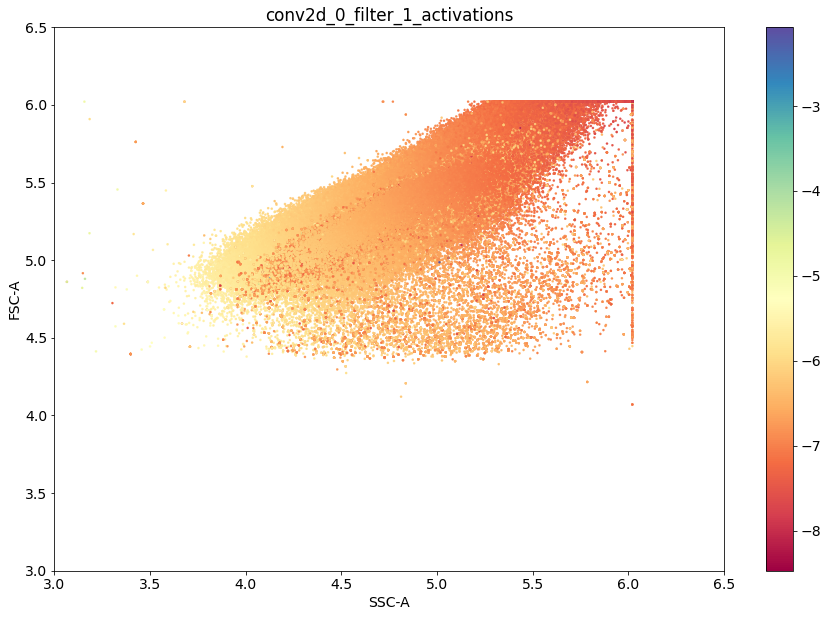

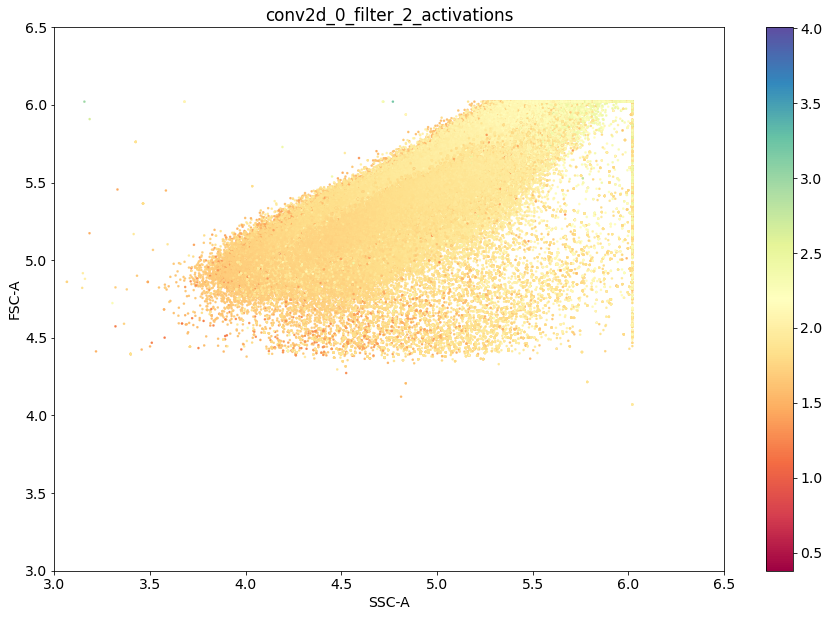

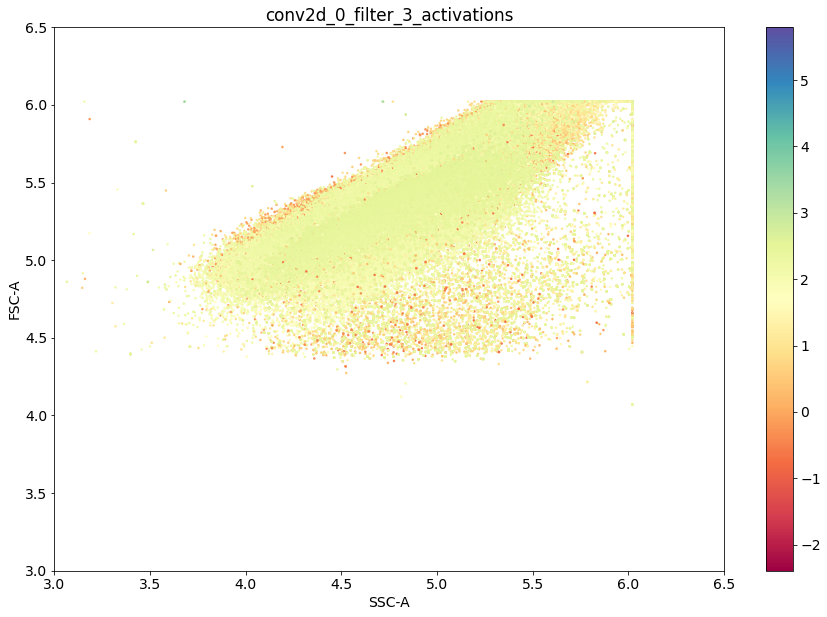

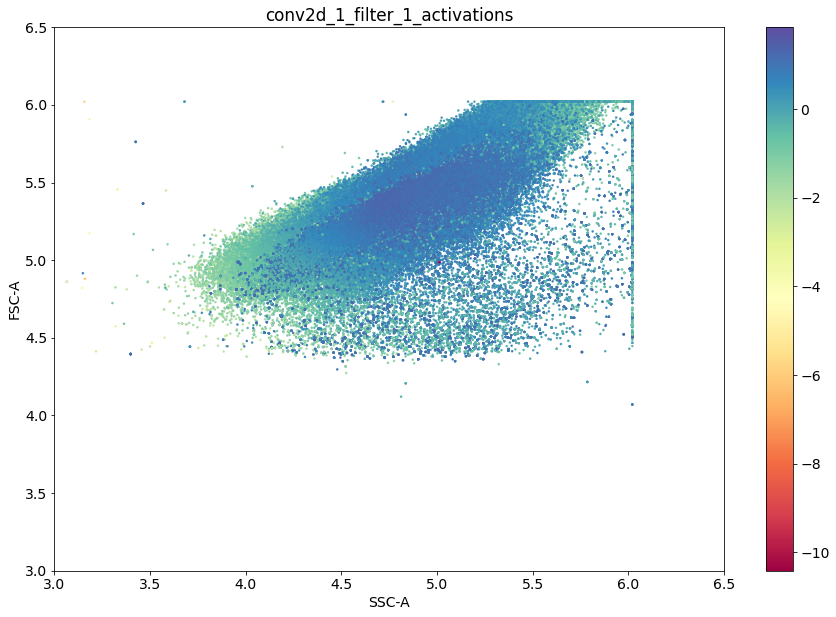

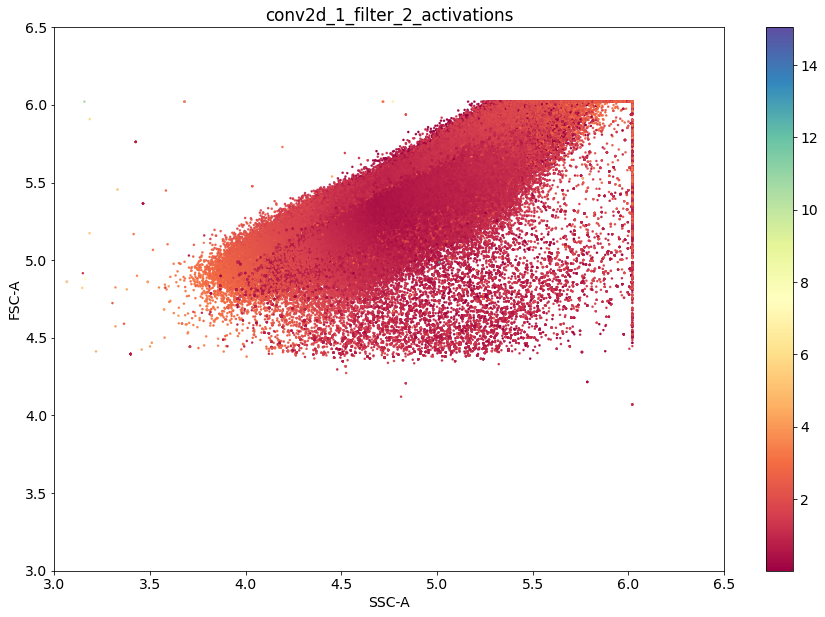

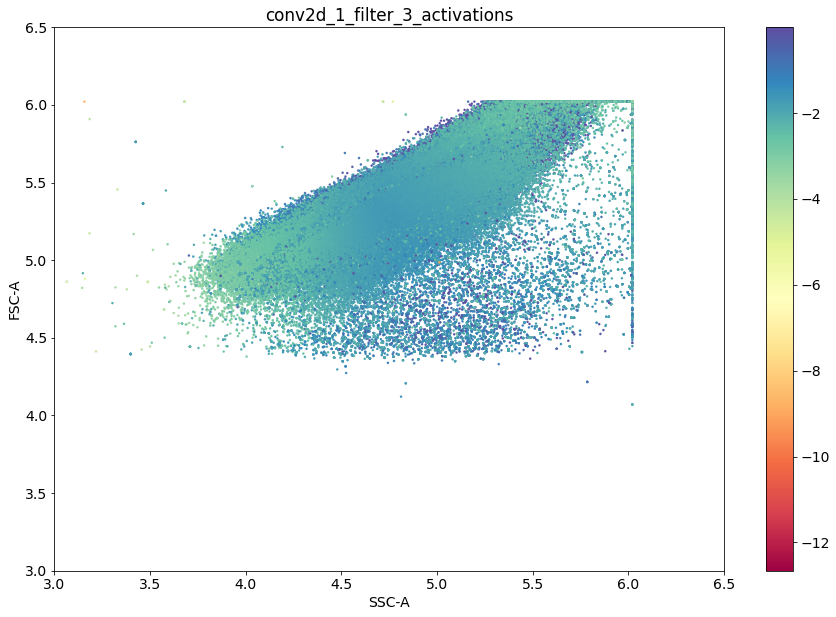

In [52]:
from scipy import stats

for filt in all_acts:
    palt = sns.color_palette("Spectral", as_cmap=True)
    
    plot_df = feat_df.copy()

    plt.figure(figsize=(15, 10))
    ax = sns.scatterplot(data=plot_df, x="SSC-A", y="FSC-A", hue=filt,
                         palette=palt, s=5, edgecolor=None)

    norm = plt.Normalize(plot_df[filt].min(), plot_df[filt].max())
    sm = plt.cm.ScalarMappable(cmap=palt, norm=norm)
    sm.set_array([])

    # Remove the legend and add a colorbar
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.title(filt)
    plt.xlim(3, 6.5)
    plt.ylim(3, 6.5)

    plt.show()

(840000, 9)
(827634, 9)
(840000, 9)
(827634, 9)
(840000, 9)
(827634, 9)
(840000, 9)
(827634, 9)
(840000, 9)
(827634, 9)
(840000, 9)
(827634, 9)


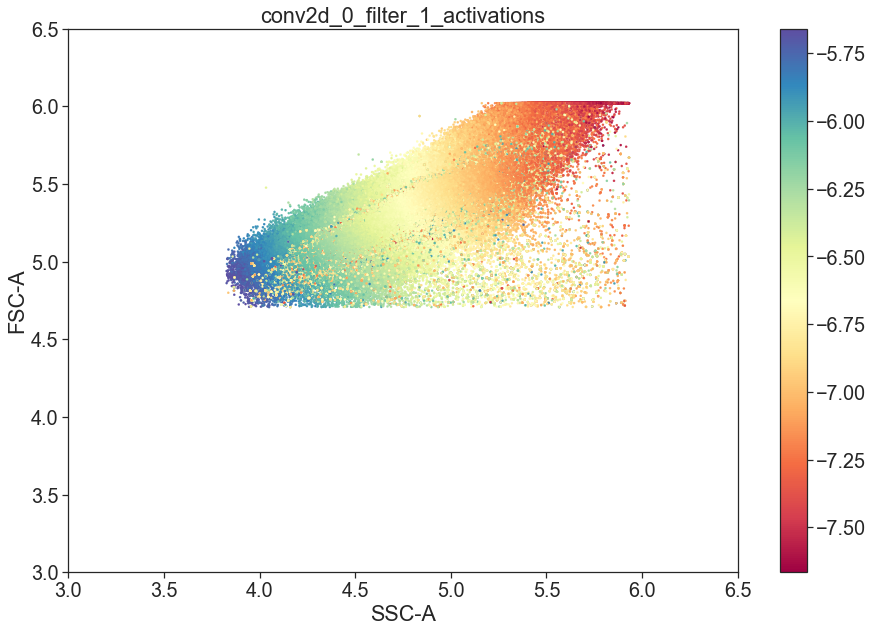

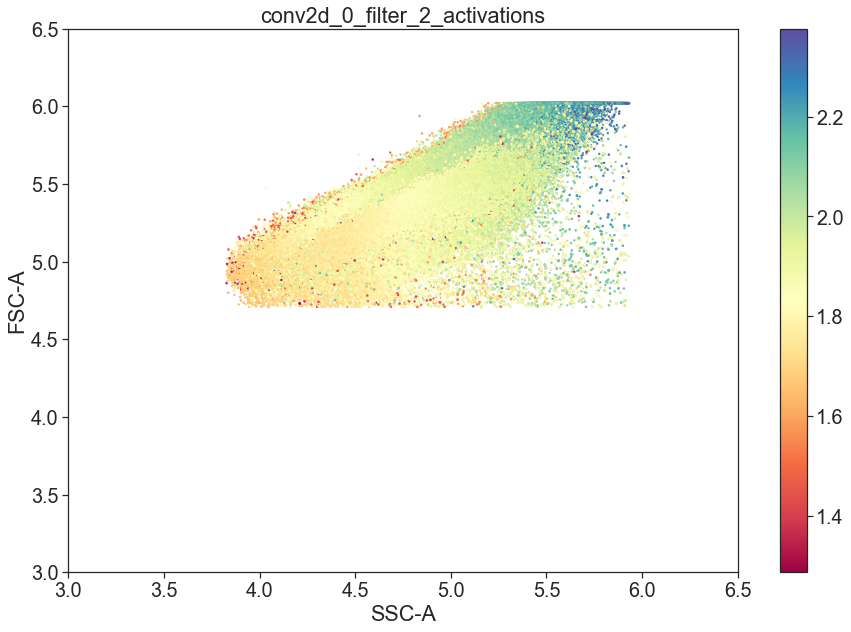

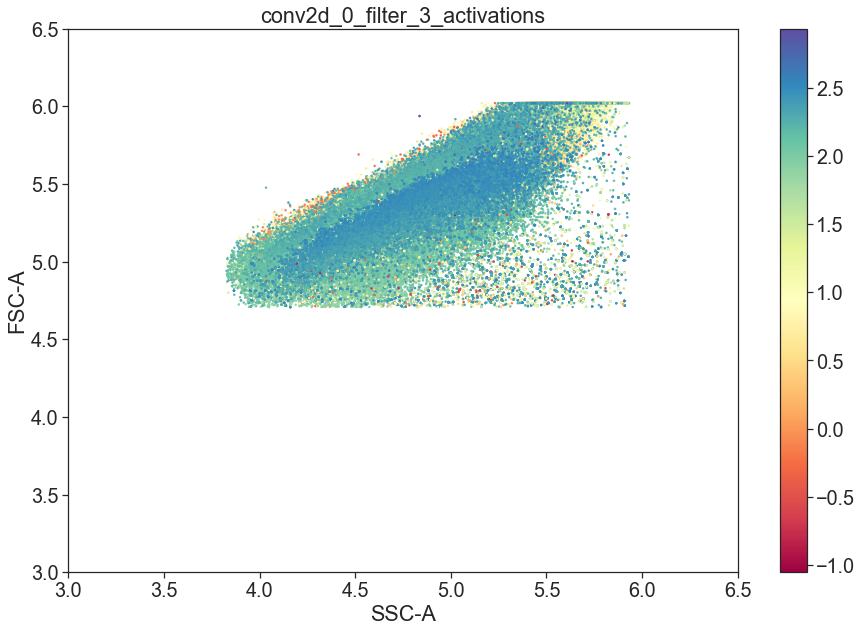

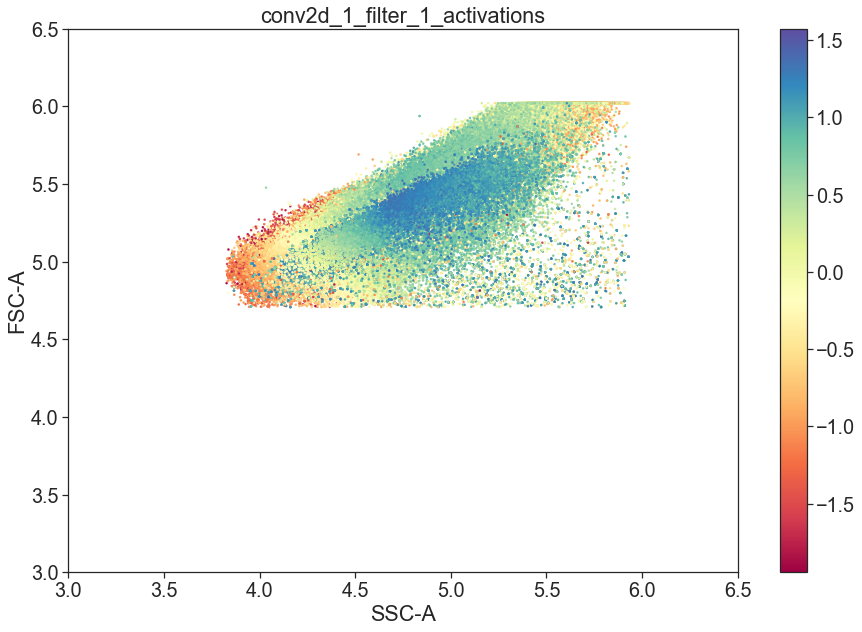

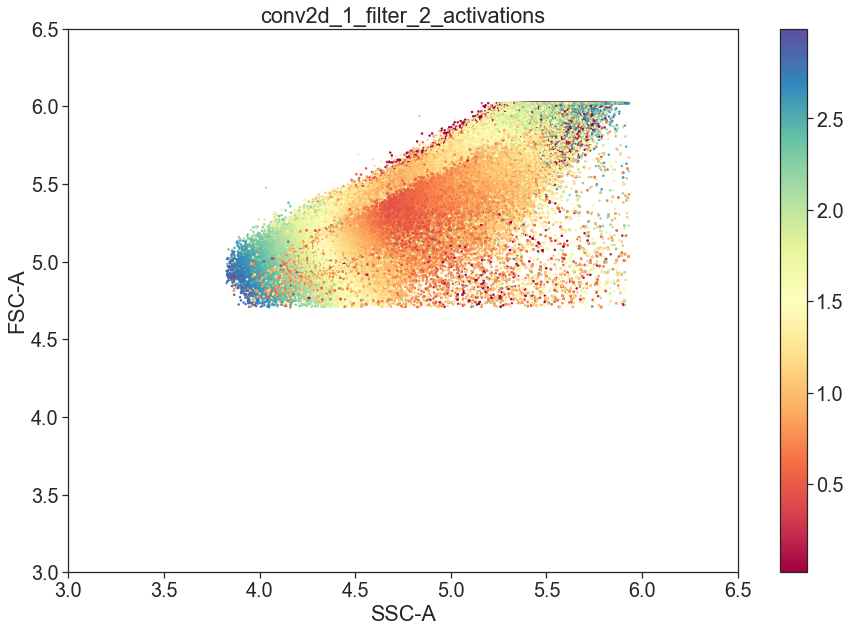

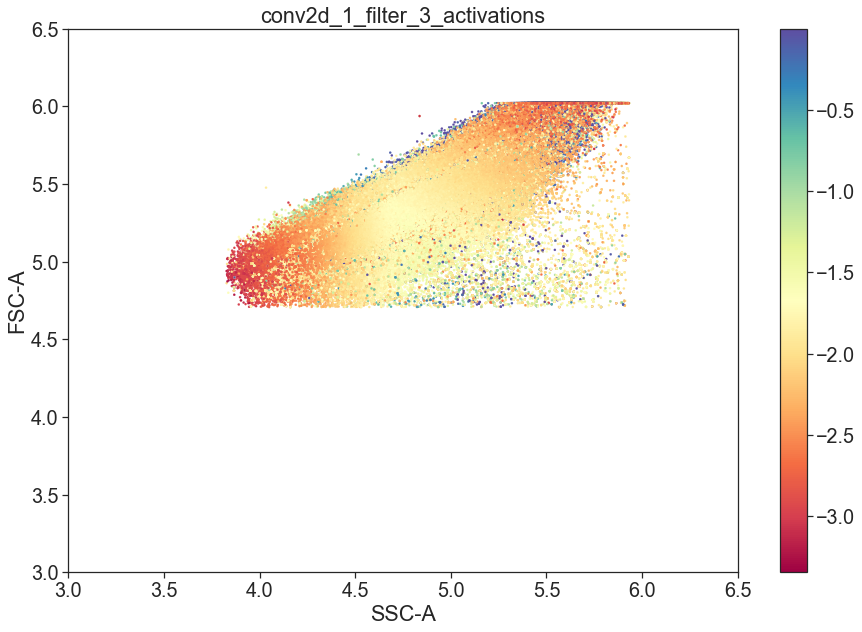

In [76]:
from scipy import stats

for filt in all_acts:
    palt = sns.color_palette("Spectral", as_cmap=True)
    
    plot_df = feat_df.copy()
    print(plot_df.shape)
    plot_df = plot_df[(np.abs(stats.zscore(plot_df)) < 3).all(axis=1)]
    print(plot_df.shape)

    plt.figure(figsize=(15, 10))
    ax = sns.scatterplot(data=plot_df, x="SSC-A", y="FSC-A", hue=filt,
                         palette=palt, s=5, edgecolor=None)

    norm = plt.Normalize(plot_df[filt].min(), plot_df[filt].max())
    sm = plt.cm.ScalarMappable(cmap=palt, norm=norm)
    sm.set_array([])

    # Remove the legend and add a colorbar
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.title(filt)
    plt.xlim(3, 6.5)
    plt.ylim(3, 6.5)

    plt.show()

# Compare with SOTA

In [54]:
kde_df = get_conc_df_with_kde_values(run_info,
                                     conc="all",
                                     features=all_features,
                                     cc="{}-H".format(color_channel_to_use))

In [68]:
point_1_that_defines_soa_line=(3.25, 4.5)
point_2_that_defines_soa_line=(4, 6.25)

Percent of AutoGater live predictions that are left of the SOA dashed line: 100.0


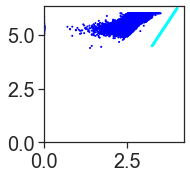

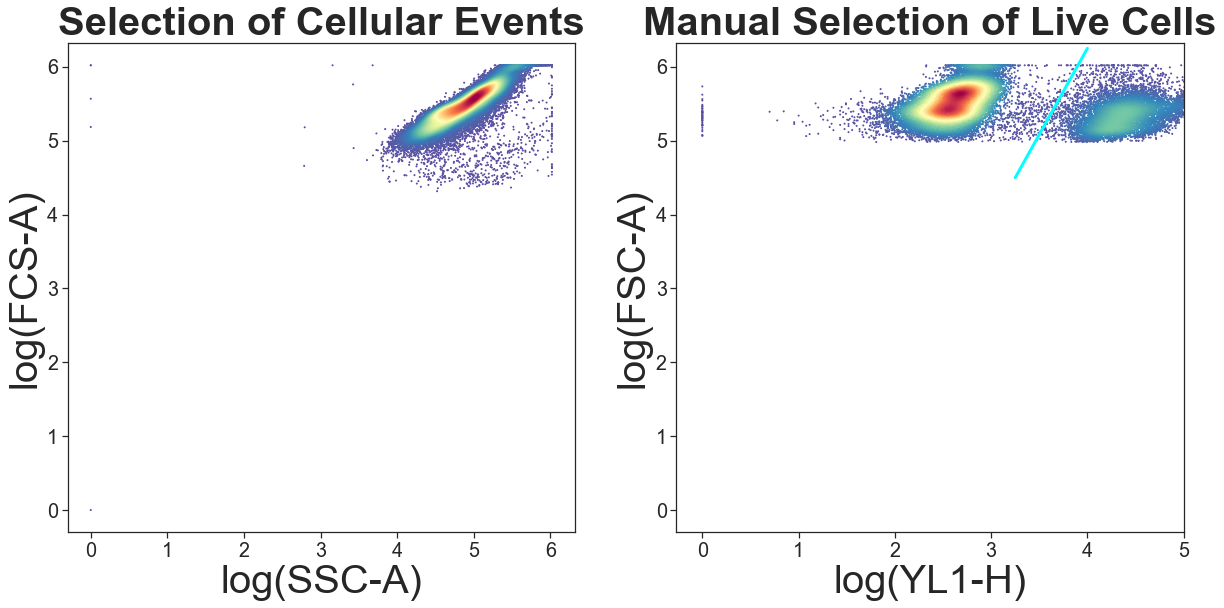

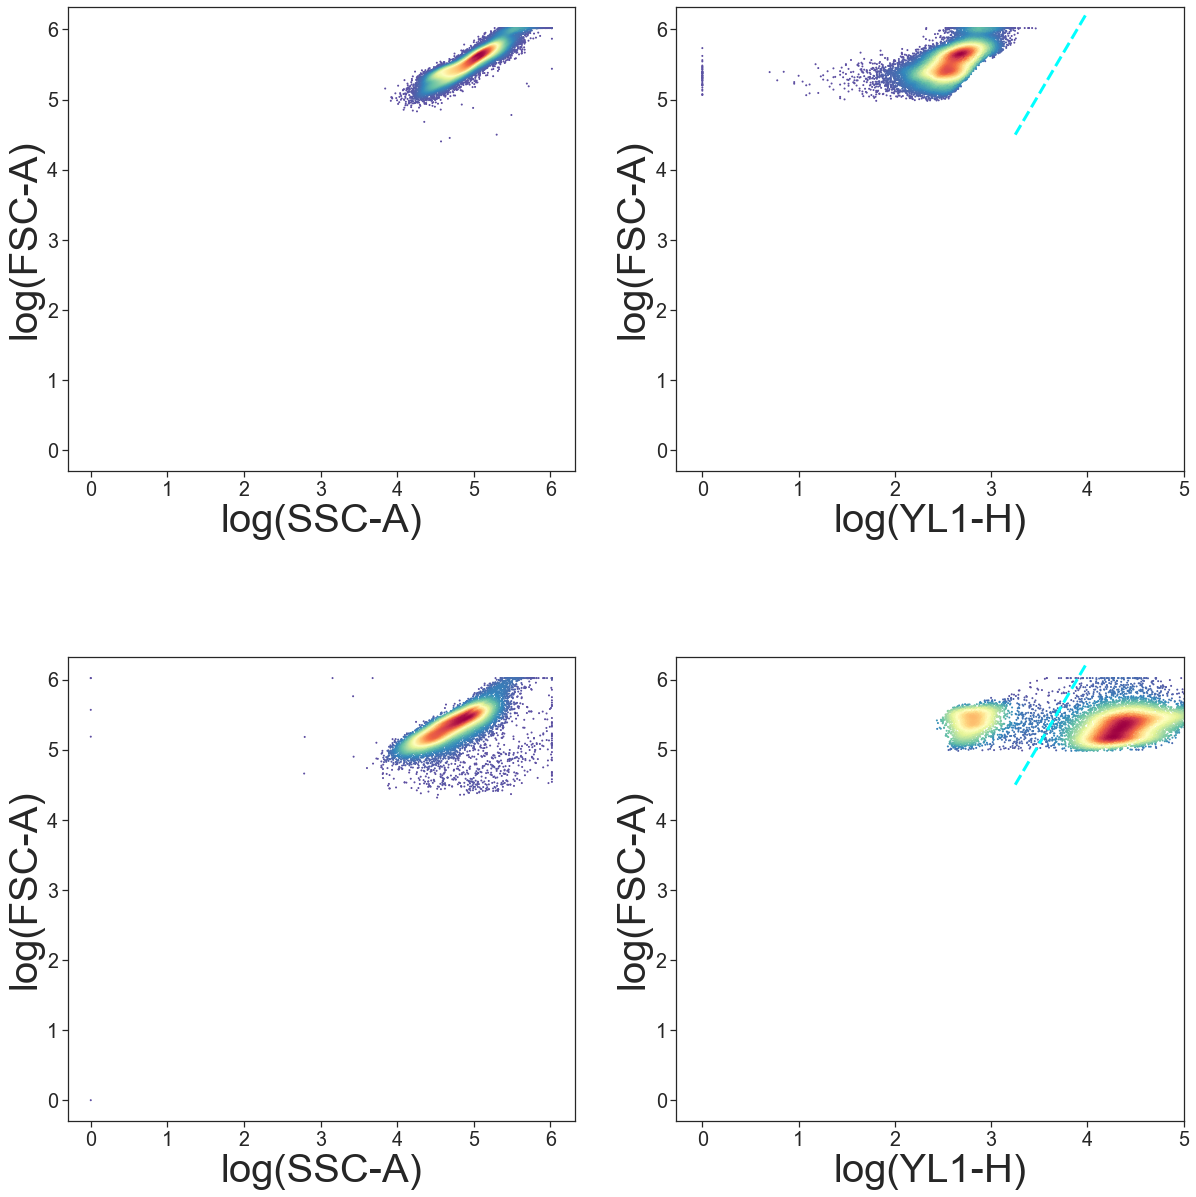

In [65]:
final_df = kde_scatter(kde_df, cc="{}-H".format(color_channel_to_use), logged=True,
                       fraction_of_points_based_on_kde=0.9,
                       point_1_that_defines_line=point_1_that_defines_soa_line, 
                       point_2_that_defines_line=point_2_that_defines_soa_line,
                       cmap="Spectral_r", pred_col="nn_preds")

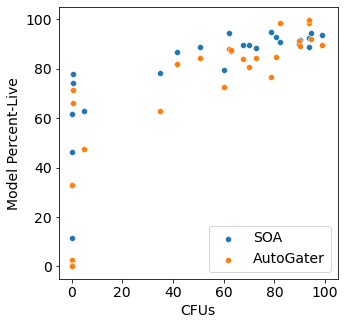

R-Squared between CFUs and State-of-the-Art predicted Percent-Live: 0.03
R-Squared between CFUs and AutoGater predicted Percent-Live: 0.4
R-Squared between CFUs and RFC predicted Percent-Live: 0.37



In [58]:
summary_table = summary_table_of_results(final_df)

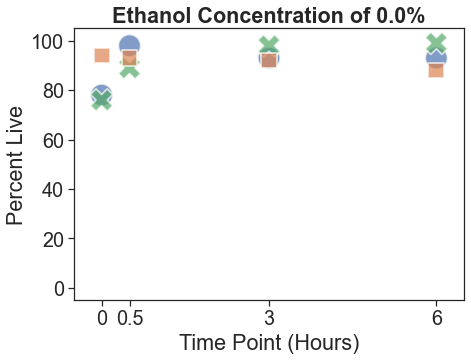

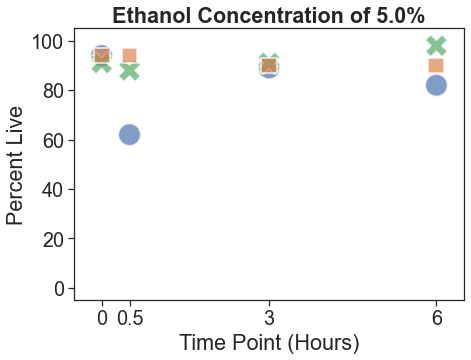

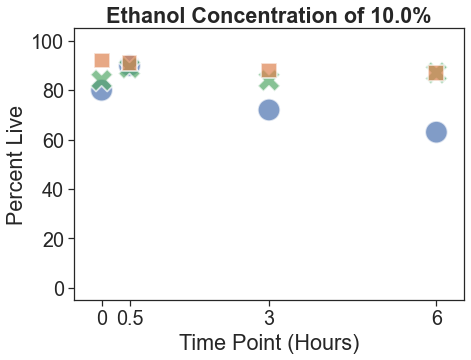

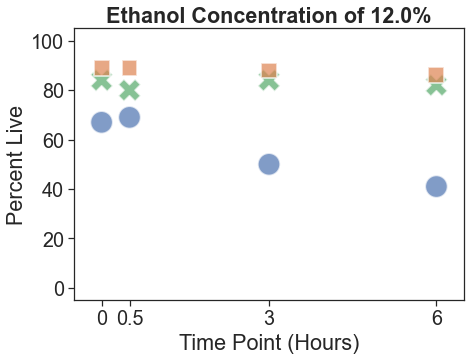

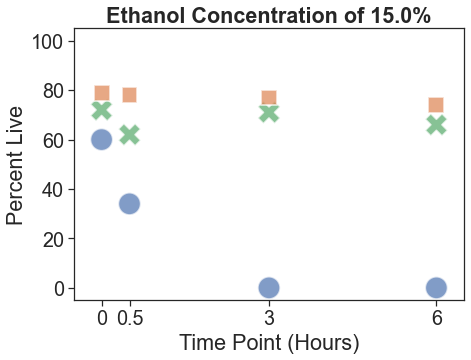

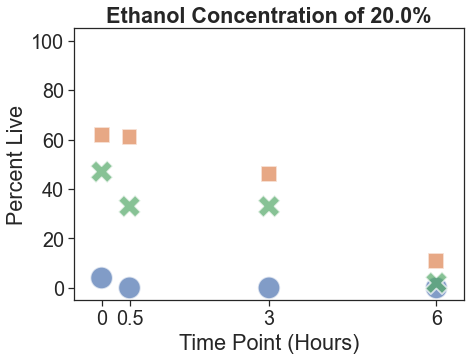

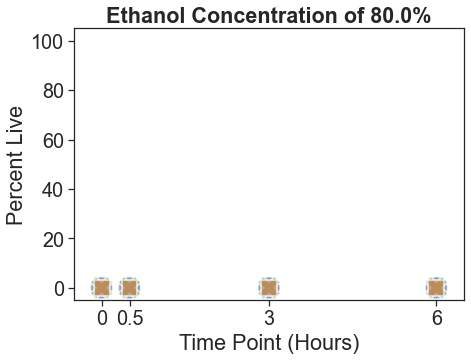

In [59]:
percent_live_comparison_plot(summary_table, legend=False)

In [83]:
# Calculate SOA_preds by getting points left of boundary line in feat_df
feat_df["SOA_preds"] = are_points_left_of_line(point_1_that_defines_line=point_1_that_defines_soa_line,
                                               point_2_that_defines_line=point_2_that_defines_soa_line,
                                               x_values=feat_df["YL1-H"],
                                               y_values=feat_df["FSC-A"]).astype(int)
soa_live_indices = feat_df.loc[feat_df["SOA_preds"] == 1].index
feat_df["SOA_preds"] = 0
feat_df.loc[soa_live_indices, 'SOA_preds'] = 1

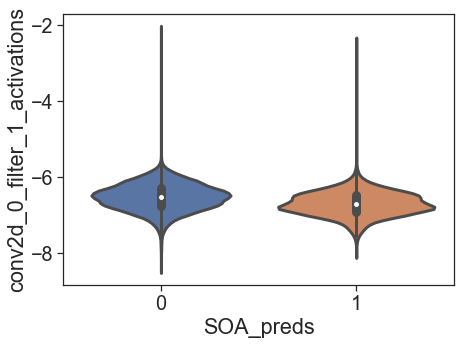

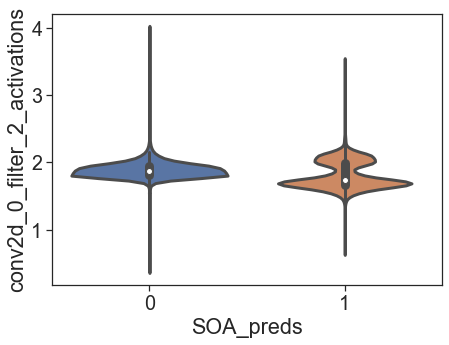

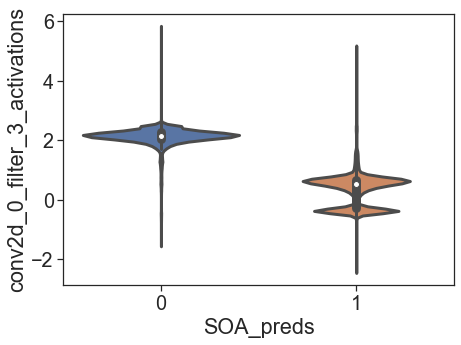

In [85]:
for cnn_filter in ["conv2d_0_filter_1_activations", "conv2d_0_filter_2_activations", "conv2d_0_filter_3_activations"]:
    matplotlib.rcParams.update({'font.size': 14})
    plt.figure(figsize=(7, 5))
    sns.violinplot(data=feat_df, x="SOA_preds", y=cnn_filter)

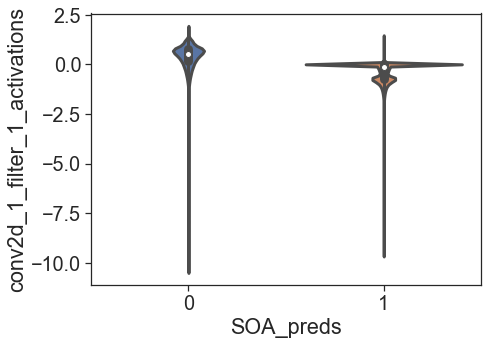

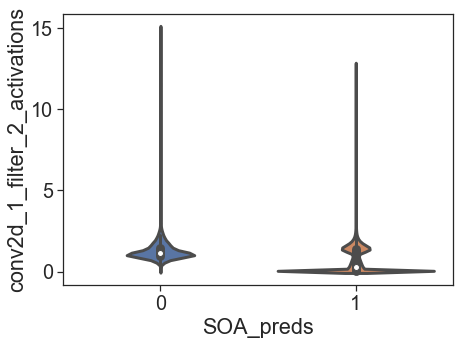

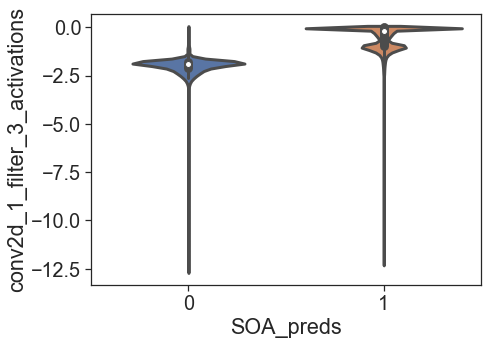

In [86]:
for cnn_filter in ["conv2d_1_filter_1_activations", "conv2d_1_filter_2_activations", "conv2d_1_filter_3_activations"]:
    matplotlib.rcParams.update({'font.size': 14})
    plt.figure(figsize=(7, 5))
    sns.violinplot(data=feat_df, x="SOA_preds", y=cnn_filter)

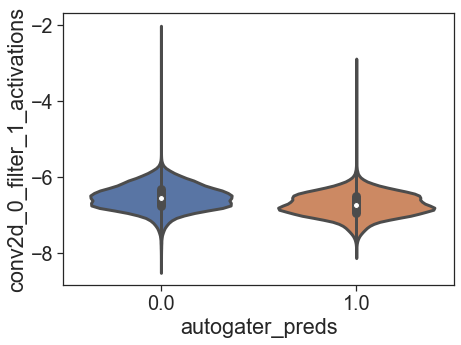

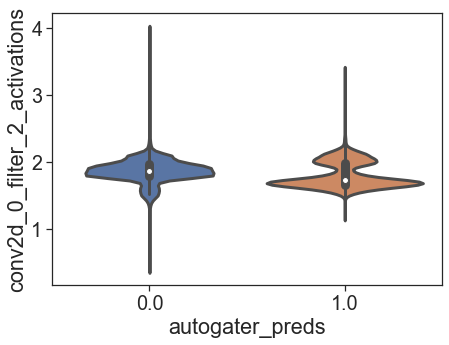

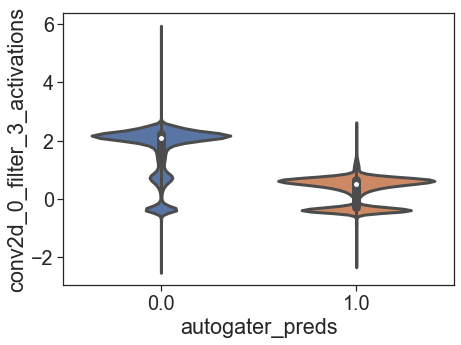

In [87]:
for cnn_filter in ["conv2d_0_filter_1_activations", "conv2d_0_filter_2_activations", "conv2d_0_filter_3_activations"]:
    matplotlib.rcParams.update({'font.size': 14})
    plt.figure(figsize=(7, 5))
#     plt.ylim(-5, 11)
    sns.violinplot(data=corr_df, x="autogater_preds", y=cnn_filter)

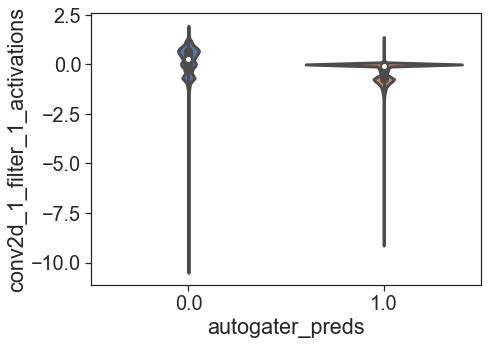

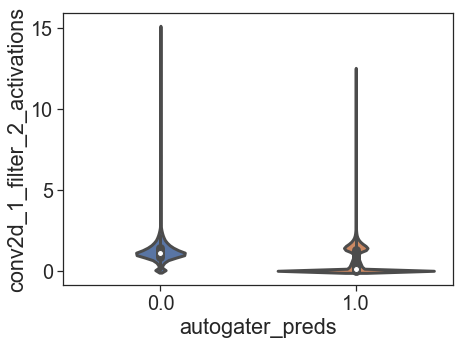

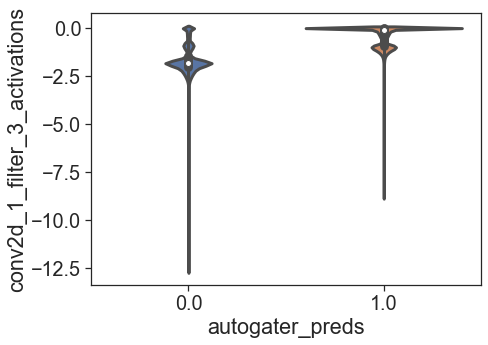

In [88]:
for cnn_filter in ["conv2d_1_filter_1_activations", "conv2d_1_filter_2_activations", "conv2d_1_filter_3_activations"]:
    matplotlib.rcParams.update({'font.size': 14})
    plt.figure(figsize=(7, 5))
#     plt.ylim(-5, 11)
    sns.violinplot(data=corr_df, x="autogater_preds", y=cnn_filter)

In [89]:
th.run_custom(function_that_returns_TH_model=random_forest_classification, dict_of_function_parameters={},
              training_data=feat_df, testing_data=feat_df, target_cols="SOA_preds", 
              feature_cols_to_use=all_acts, description="predict SOA_preds from 6 CNN Activations", 
              index_cols=all_acts)

----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 13:08:17
Starting Classification training...
Training time was: 288.11 seconds
Testing time was: 15.73 seconds
Run finished at 13:13:37. Total run time = 319.19 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




In [91]:
th.run_custom(function_that_returns_TH_model=random_forest_classification, dict_of_function_parameters={},
              training_data=feat_df, testing_data=feat_df, target_cols="autogater_preds", 
              feature_cols_to_use=all_acts, description="predict autogater_preds from 6 CNN Activations", 
              index_cols=all_acts)

----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 13:13:37
Starting Classification training...
Training time was: 295.65 seconds
Testing time was: 22.99 seconds
Run finished at 13:19:14. Total run time = 336.71 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




# Model 2: sample-level prediction of live/dead based on stain value majority

# Model 3: sample-level prediction of concentration

# Model 4: sample-level prediction of CFU percent_live